# ZILLOW HOUSING DATA TIME SERIES ANALYSIS

## BUSINESS UNDERSTANDING 

### PROBLEM STATEMENT

Real investment firms weigh on many factors when decided on which investment to make. These firms’ goals are to enhance their decision making processes. With historical real estate market data, the challenge is to leverage data science techniques to identify potential investment opportunities and helping the real estate firms in making informed investment decisions.

### OBJECTIVES
Main Objectives:
* Identify the 5 best zip codes.

Secondary Objectives:
* Predict the prices of the best 5 zipcodes. 

In [127]:
## Importing the necessary Libraries
import pandas as pd
import matplotlib.pyplot as plt


## DATA UNDERSTANDING

#### Load the dataset

This project uses data from ZIllow housing data,  found [here](https://www.zillow.com/research/data/)

In [26]:
data = pd.read_csv("data/zillow_data.csv")
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


The dataset contains 14723 rows and 272 columns.    
Each of the row is an individual property.    
The dataset as seen is in a Wide format. Columns 1-7 show the different properties of a house.    
However,  column 8 to column 272 are actual time series values. The columns refer to the median house sales values for their respective month and year.      
This format makes the dataframe intuitive and easy to read. However problems with this dataset may come in when it comes to actually learning from the data. We'll deal with that when we get there.   
The first 7 columns represent:
* RegionID - The Regional ID for the region where a house is located.
* RegionName - The Zipcode. 
* City - The City of a particular house. 
* State - The state in which a home is in. 
* Metro - The metropolitan area where the home is found. 
* CountyName - The county where the home is in. 
* SizeRank - Hapa sijui. 

Drop the unnecessary columns and rename the RegionName to zipcode

In [4]:
#  drop the unnecessary columns
data.drop(["RegionID", "Metro", "SizeRank"], axis=1, inplace=True)

# rename the RegionName to ZipCode
data.rename({"RegionName":"ZipCode"}, axis=1 , inplace=True)

We can reshape the dataset to a Long Format. 

In [5]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['ZipCode', 'City', 'State',  'CountyName'], var_name='time')
    # melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    # melted = melted.dropna(subset=['value'])
    return melted

melted_data = melt_data(data) 
melted_data.head()

,ZipCode,City,State,CountyName,time,value
0,60657,Chicago,IL,Cook,1996-04,334200.0
1,75070,McKinney,TX,Collin,1996-04,235700.0
2,77494,Katy,TX,Harris,1996-04,210400.0
3,60614,Chicago,IL,Cook,1996-04,498100.0
4,79936,El Paso,TX,El Paso,1996-04,77300.0


In [6]:
melted_data.isna().sum()

ZipCode            0
City               0
State              0
CountyName         0
time               0
value         156891
dtype: int64

There are no duplicates

In [7]:
melted_data["State"].value_counts()

State
CA    324360
NY    268975
TX    262085
PA    220215
FL    208025
OH    155820
IL    144955
NJ    133030
MI    132235
IN    113420
NC    113420
MA    110505
TN    107060
VA    106265
MN     99375
GA     91425
WA     90365
WI     87980
MO     84535
MD     84005
CO     65985
KS     63865
AZ     60950
OR     59360
OK     58565
SC     54590
NH     52735
LA     51145
AL     48495
IA     41870
MS     40545
KY     36835
CT     32860
UT     32065
ID     29150
AR     27825
NV     27295
ME     22790
NE     21995
WV     19080
MT     18815
HI     16430
NM     15900
RI     15635
DE     10865
ND      8215
WY      8215
AK      7420
SD      5035
DC      4770
VT      4240
Name: count, dtype: int64

In [25]:
melted_data["time"].value_counts()

time
1996-04    14723
2011-06    14723
2010-04    14723
2010-05    14723
2010-06    14723
           ...  
2004-02    14723
2004-03    14723
2004-04    14723
2004-05    14723
2018-04    14723
Name: count, Length: 265, dtype: int64

### Exploratory Data Analysis And Visualization

For computational efficiency, we will have to work with one out of the 51 states.  
We will work with Washington DC. 

In [35]:
df = melted_data[melted_data["State"] == "DC"]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4770 entries, 29 to 3893759
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     4770 non-null   int64  
 1   City        4770 non-null   object 
 2   State       4770 non-null   object 
 3   CountyName  4770 non-null   object 
 4   time        4770 non-null   object 
 5   value       4770 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 260.9+ KB


DC Washington has 4770 properties.   
We will need to group our data to zipcodes and have the time as our index to be able to manipulate the dataframe better. 

In [83]:
# Change the time column to a DataFram Object.
# df["time"] = pd.to_datetime(df["time"], format="%Y-%m")
 
# # Set the time column as the index.
# df.set_index("time", inplace=True)



In [105]:
df.loc['2018-04-01']["value"]

time
2018-04-01     691300.0
2018-04-01    1078200.0
2018-04-01     619100.0
2018-04-01     308600.0
2018-04-01     793300.0
2018-04-01     337000.0
2018-04-01    1545900.0
2018-04-01     820200.0
2018-04-01     307400.0
2018-04-01    1199500.0
2018-04-01     778200.0
2018-04-01    1290000.0
2018-04-01     885000.0
2018-04-01     548900.0
2018-04-01     554100.0
2018-04-01    1019600.0
2018-04-01    1004000.0
2018-04-01     730700.0
Name: value, dtype: float64

In [90]:
df.index[-1] - pd.DateOffset(years=3)

Timestamp('2015-04-01 00:00:00')

We will select the best zipcodes with `ROI` as our metric. 
`ROI` is the Return on Investment.   
We will use a long term term period , 10 years, in calculating the ROI because our dataset only has  home values.   
My logic is that in the long term, holding a property for increase in its value is the best strategy. 
ROI is calculated as: (Final Value - Initial Value) / Initial Value * 100

In [121]:
def ROI (df, frequency=10):
    """
    This function takes in a dataframe and returns the Zipcodes with the best ROI for a given frequency. eg 3 year best ROI for the last 3 years
    """ 
    zipcode_roi = {}
    zipcodes = zipcodes = list(df["ZipCode"].unique())
    end_date = df.index[-1]
    start_date = df.index[-1] - pd.DateOffset(years=frequency)
    for zipcode in zipcodes:
        roi = ((df[df["ZipCode"] == zipcode].loc[end_date]["value"] - df[df["ZipCode"] == zipcode].loc[start_date]["value"])  / df[df["ZipCode"] == zipcode].loc[start_date]["value"]) * 100
        zipcode_roi[zipcode] = roi
    return zipcode_roi

roi_dict = ROI(df, 4)
# Get the top 5 zip codes and their ROI
top_5_zipcodes = sorted(roi_dict.items(), key=lambda x: x[1], reverse=True)[:5]

# Display the result
top_5 = []
for zipcode, roi in top_5_zipcodes:
    print(f"Zip Code: {zipcode}, ROI: {roi}")
    top_5.append(zipcode)

Zip Code: 20032, ROI: 62.130801687763714
Zip Code: 20019, ROI: 58.33760903027193
Zip Code: 20017, ROI: 47.1976401179941
Zip Code: 20020, ROI: 46.969036197121675
Zip Code: 20011, ROI: 44.54821386878356


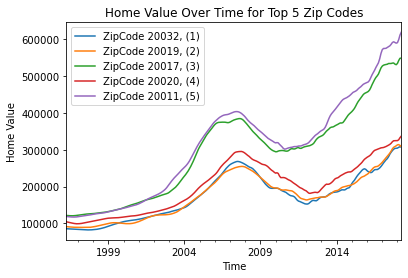

In [133]:
# for zipcode in top_5:
#     time_data = df[df["ZipCode"] == zipcode]["value"]
#     time_data.plot(ylabel="Home value", )
num = 0
for zipcode in top_5:
    num += 1
    time_data = df[df["ZipCode"] == zipcode]["value"]
    time_data.plot(label=f'ZipCode {zipcode}, ({num})')

plt.title('Home Value Over Time for Top 5 Zip Codes')
plt.xlabel('Time')
plt.ylabel('Home Value')
plt.legend()
plt.show()